# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model 
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
# Additional research
# Investigations of categorical signs in dataResearch.ipynb

churn_data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


array([[<Axes: title={'center': 'RowNumber'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>, <Axes: >]], dtype=object)

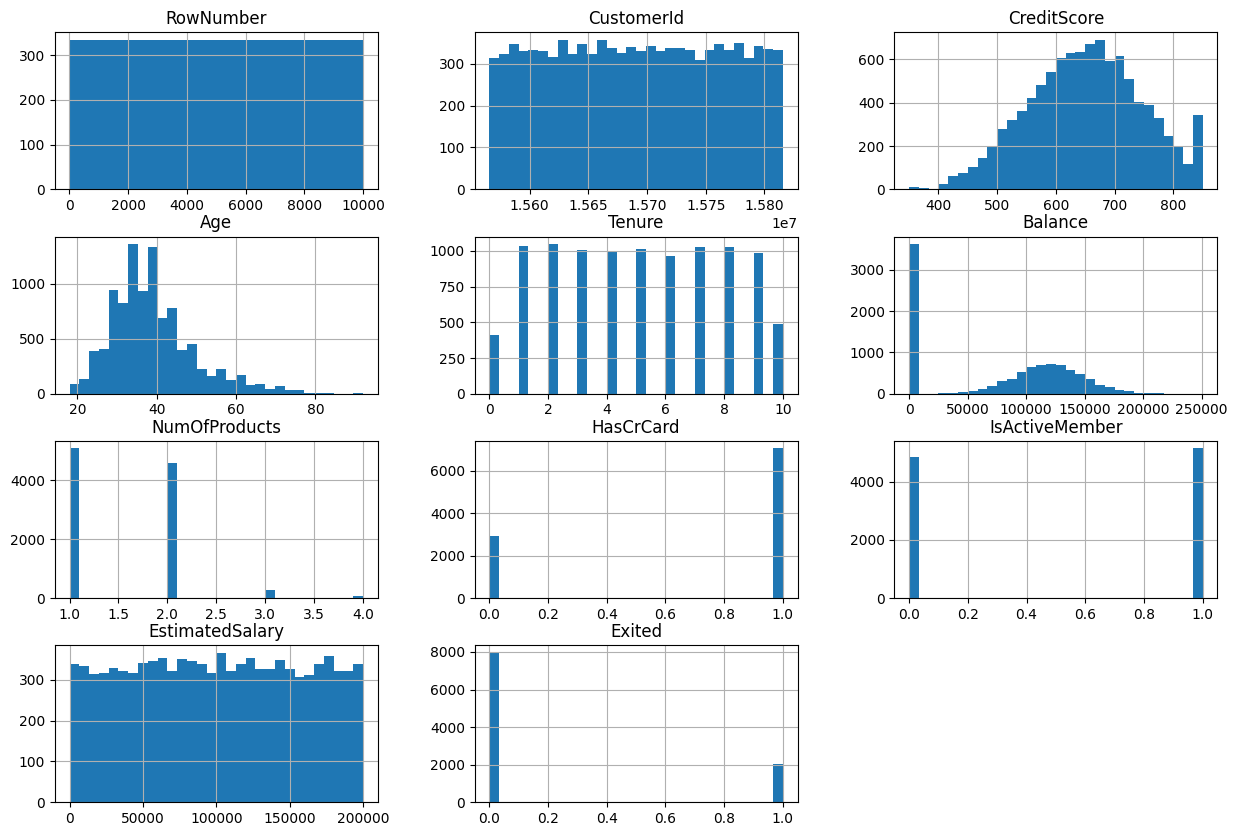

In [4]:
# Visual analysis of distributions of numerical features
numericalColumns = churn_data.select_dtypes(include='number').columns.to_list()

churn_data[numericalColumns].hist(figsize=(15, 10), bins=30)

* Распределение баланса является нормальным, если не учитывать клиентов с пустым балансом, проверим, различаются ли количество ушедших клиентов среди людей с нулевым балансом и отличным от нуля
* Распределение возраста является лог-нормальным

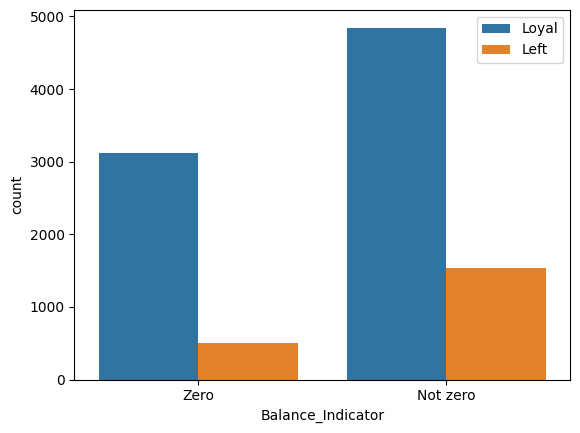

In [5]:
churn_data['Balance_Indicator'] = churn_data['Balance'].apply(
    lambda x: 'Zero' if not x else 'Not zero'
)
sns.countplot(
    data=churn_data,
    x='Balance_Indicator',
    hue='Exited'
)
plt.legend(['Loyal', 'Left'])
plt.show()

# Delete useless information
churn_data = churn_data.drop('Balance_Indicator', axis=1)

Видно, что число ушедших клиентов среди тех, у кого ненулевой баланс, более чем в два раза больше

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [6]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [7]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [8]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [9]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

In [10]:
# Remove outliers using the interquartile range method
def outliers_iqr(data: pd.DataFrame, feature: str, left: float=1.5, right: float=1.5, log_scale: bool=False) -> tuple:
    """The function determines outliers using the interquartile range method
(Tukey method)

    Args:
        data (pd.DataFrame): Source dataset
        feature (str): Sign for cleaning
        left (float, optional): Left limit of normal values(relative to box width). Defaults to 1.5.
        right (float, optional): Right limit of normal values(relative to box width). Defaults to 1.5.
        log_scale (bool, optional): Feature logarithm. Defaults to False.

    Returns:
        tuple: Outliers and Cleaned Dataset
    """
    if log_scale: # Logarithm
        x = np.log(data[feature])
    else:
        x = data[feature]
    
    # Box borders
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    
    iqr = quartile_3 - quartile_1
    
    # Threshold of normal values
    upper_bound = quartile_3 + right*iqr
    lower_bound = quartile_1 - left*iqr
    
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    
    return outliers, cleaned


# Normal destribution columns
normalDestrColumns = ['Age', 'Balance', 'CreditScore']

# Remove outliers for each feature, taking into account the distribution
for col in normalDestrColumns:
    if col == 'Age':
        outliers, churn_data = outliers_iqr(churn_data, col, log_scale=True)
    else:
        outliers, churn_data = outliers_iqr(churn_data, col)
        
    print(f'Number of Tukey outliers in a trait "{col}": {outliers.shape[0]}')
    
# Copy for prediction
churn_df = churn_data.copy(deep=True)
    
print(f'Resulting Number of Records: {churn_data.shape[0]}')

Number of Tukey outliers in a trait(train sample) "Age": 24
Number of Tukey outliers in a trait(train sample) "Balance": 33
Number of Tukey outliers in a trait(train sample) "CreditScore": 3
Resulting Number of Records: 2449


### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [11]:
# Creating features
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# Encoding by Category Encoders
types = churn_data.dtypes
categoricalFeatures = list(types[types == 'object'].index)

encoder = ce.OneHotEncoder(cols=categoricalFeatures, use_cat_names=True)
churn_data_enc = encoder.fit_transform(churn_data[categoricalFeatures])
churn_data = pd.concat([churn_data, churn_data_enc], axis=1)

# Delete useless
churn_data = churn_data.drop(categoricalFeatures, axis=1)

churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,Gender_Male
count,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000,2449.000000
mean,651.687628,39.763169,5.017967,119976.443614,1.519396,0.714169,0.496121,101062.332977,0.330747,9.099609,0.134150,17.455584,0.477746,0.522254
std,98.069816,10.150876,2.932883,25543.727409,0.621421,0.451902,0.500087,58231.182597,0.470578,216.845413,0.086827,5.147645,0.499607,0.499607
min,376.000000,20.000000,0.000000,51293.470000,1.000000,0.000000,0.000000,11.580000,0.000000,0.295164,0.000000,6.112676,0.000000,0.000000
25%,584.000000,32.000000,2.000000,103163.350000,1.000000,0.000000,0.000000,51016.020000,0.000000,0.785804,0.061538,13.688889,0.000000,0.000000
50%,651.000000,38.000000,5.000000,119755.000000,1.000000,1.000000,0.000000,102184.660000,0.000000,1.197635,0.125000,16.816327,0.000000,1.000000
75%,723.000000,45.000000,8.000000,137455.990000,2.000000,1.000000,1.000000,150856.380000,1.000000,2.405217,0.200000,20.800000,1.000000,1.000000
max,850.000000,75.000000,10.000000,188976.890000,4.000000,1.000000,1.000000,199970.740000,1.000000,10614.655440,0.454545,41.750000,1.000000,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [12]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [13]:
y.value_counts(normalize=True).round(2)

Exited
0    0.67
1    0.33
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 33 %, в то время как лояльных — 67 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=42
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1836, 13)
Test shape: (613, 13)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [15]:
print('Train :')
display(y_train.value_counts(normalize=True).round(2))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True).round(2))

Train :


Exited
0    0.67
1    0.33
Name: proportion, dtype: float64



Test :


Exited
0    0.67
1    0.33
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [16]:
# Standartization by StandartScaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Так как нужно соблюсти баланс между количеством ложноположительных(FP) и ложноотрицательных(FN) срабатываний необходимо использовать F1-меру, являющейся взвешенным средним гармоническим между полнотой(recall) и точностью(precision) алгоритма, которые как раз характеризуют ложноотрицательные и ложноположительные срабатывания соответственно

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Необходимо достичь как можно большего значения метрики, так как она увеличивается только при одновременном росте ее параметров(precision и recall) в силу ее математического описания, чем больше F1-мера - тем меньше алгоритм выдает ложных результатов, однако это непросто, так как зачастую увеличение одной метрики(например, precision) ведет к уменьшению другой. Для оптимального выбора требуется провести подбор порога срабатывания алгоритма(оценка вероятности, которая является определяющей при отношении объекта к определенному классу, по умолчанию=0.5)

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Train:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1229
           1       0.64      0.44      0.52       607

    accuracy                           0.73      1836
   macro avg       0.70      0.66      0.67      1836
weighted avg       0.72      0.73      0.72      1836

Test:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       410
           1       0.65      0.43      0.52       203

    accuracy                           0.73       613
   macro avg       0.70      0.66      0.67       613
weighted avg       0.72      0.73      0.72       613



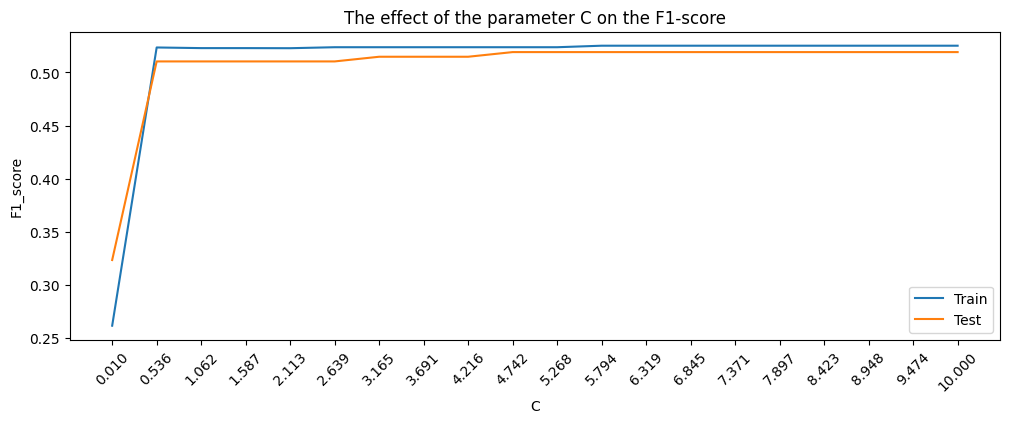

Final metric: 0.52


In [17]:
log_reg = linear_model.LogisticRegression(
    solver='saga',
    penalty='l1',
    random_state=42,
    max_iter=10000,
    C=5
)

log_reg.fit(X_train_scaled, y_train)

# Prediction for a training sample
y_train_pred = log_reg.predict(X_train_scaled)

# Report on Classification metrics
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))

# Prediction for a test sample
y_test_pred = log_reg.predict(X_test_scaled)

# Report on Classification metrics
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

# Selection of parameter C
# Creating a list of 20 possible values from 0.001 to 10
c_list = np.linspace(0.01, 10, 20)

# Creating empty lists to which we will add the results 
train_scores = []
test_scores = []

for c in c_list:
    # Creating an object of the linear regression class with L1-regularization (SGD)
    log_redr_mod = linear_model.LogisticRegression(C=c, max_iter=10000, random_state=42, solver='saga', penalty='l1')
    
    # Training the model 
    log_redr_mod.fit(X_train_scaled, y_train)
    
    #  Make a prediction for each of the samples
    y_train_predict = log_redr_mod.predict(X_train_scaled)
    y_test_predict = log_redr_mod.predict(X_test_scaled)
    
    train_scores.append(metrics.f1_score(y_train, y_train_predict))
    test_scores.append(metrics.f1_score(y_test, y_test_predict))

# F1_score visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Lines
ax.plot(c_list, train_scores, label='Train')
ax.plot(c_list, test_scores, label='Test')

# Labels
ax.set_xlabel('C')
ax.set_ylabel('F1_score')
ax.set_title('The effect of the parameter C on the F1-score')

# Ticks
ax.set_xticks(c_list)
ax.xaxis.set_tick_params(rotation=45)

# Legend
ax.legend()

plt.show()

print('Final metric:', metrics.f1_score(y_test, y_test_pred).round(2))

> При анализе коэффициента, обратного коэффициенту регуляризации(C), представленном на графике, подобрали оптимальное значение, при котором значение F1-меры на тестовой выборке наибольшее, при этом удалось достигнуть необходимого значения (0.5), так же очистка данных от выбросов методом Тьюки позволила улучшить метрику. С точки зрения нормализации данных лучшее влияние на метрику оказала стандартизация с помощью StandartScaler. Что касается численных методов решения задачи логистической регрессии - лучше всего себя показал Стохастический градиентный спуск с l1 регуляризацией. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Train:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1229
           1       0.61      0.62      0.62       607

    accuracy                           0.75      1836
   macro avg       0.71      0.71      0.71      1836
weighted avg       0.75      0.75      0.75      1836

Test:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       410
           1       0.61      0.61      0.61       203

    accuracy                           0.74       613
   macro avg       0.71      0.71      0.71       613
weighted avg       0.74      0.74      0.74       613



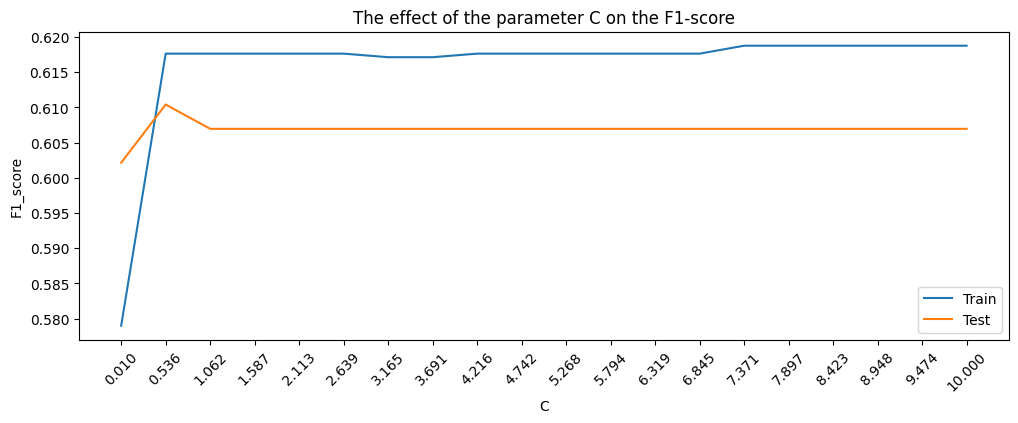

Final metric: 0.61


In [18]:
# Create a polynomical features
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

# Creating an object of the linear regression class with L1-regularization (SGD)
log_reg_poly = linear_model.LogisticRegression(
    solver='saga',
    penalty='l1',
    random_state=42,
    max_iter=1000,
    C=0.536
)

# Training the model
log_reg_poly.fit(X_train_scaled_poly, y_train)

# Prediction for a training sample
y_train_pred = log_reg_poly.predict(X_train_scaled_poly)

# Report on Classification metrics
print('Train:')
print(metrics.classification_report(y_train, y_train_pred))

# Prediction for a test sample
y_test_pred = log_reg_poly.predict(X_test_scaled_poly)

# Report on Classification metrics
print('Test:')
print(metrics.classification_report(y_test, y_test_pred))

# Selection of parameter C
# Creating a list of 20 possible values from 0.001 to 10
c_list = np.linspace(0.01, 10, 20)

# Creating empty lists to which we will add the results 
train_scores = []
test_scores = []

for c in c_list:
    # Creating an object of the linear regression class with L1-regularization (SGD)
    log_redr_mod = linear_model.LogisticRegression(C=c, max_iter=1000, random_state=42, solver='saga', penalty='l1')
    
    # Training the model 
    log_redr_mod.fit(X_train_scaled_poly, y_train)
    
    #  Make a prediction for each of the samples
    y_train_predict = log_redr_mod.predict(X_train_scaled_poly)
    y_test_predict = log_redr_mod.predict(X_test_scaled_poly)
    
    train_scores.append(metrics.f1_score(y_train, y_train_predict))
    test_scores.append(metrics.f1_score(y_test, y_test_predict))

# F1_score visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Lines
ax.plot(c_list, train_scores, label='Train')
ax.plot(c_list, test_scores, label='Test')

# Labels
ax.set_xlabel('C')
ax.set_ylabel('F1_score')
ax.set_title('The effect of the parameter C on the F1-score')

# Ticks
ax.set_xticks(c_list)
ax.xaxis.set_tick_params(rotation=45)

# Legend
ax.legend()

plt.show()

print('Final metric:', metrics.f1_score(y_test, y_test_pred).round(2))

> Использование полиномиальных признаков увеличивает количество факторов почти до 600, при этом численное решение занимает большее время, а метрика увеличивается на 0.1, так же замечено, что за тысячу итераций алгоритм не успевает сойтись, при этом за десять тысяч - сходится, однако это почти не оказывает влияния на итоговую метрику(но при десяти тысячах итераций время обучения значительно увеличивается). Согласно графика зависимости коэффициента C наименьшая разница в метриках на тестовой и тренировочной выборках достигается при значении коэффициента C=0.536

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

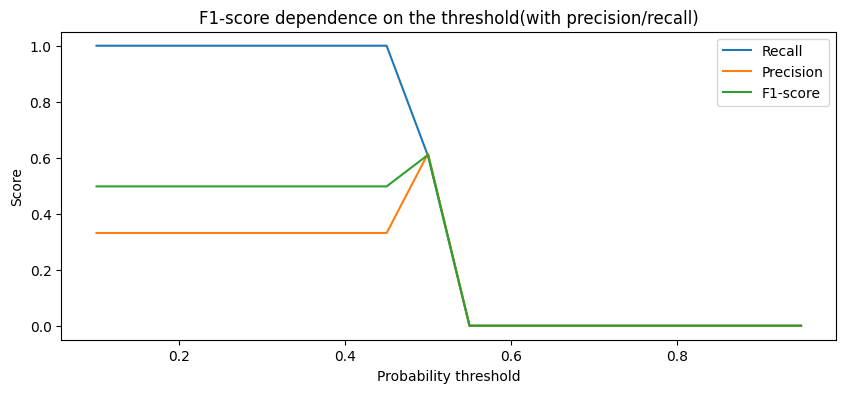

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       410
           1       0.61      0.61      0.61       203

    accuracy                           0.74       613
   macro avg       0.71      0.71      0.71       613
weighted avg       0.74      0.74      0.74       613



In [19]:
# Let's highlight the estimates of the probability of predictions
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1])

# Lists of metrics 
recall_scores = []
precision_scores = []
f1_scores = []

# Thresholds for probability estimation
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    # If the probability estimate is greater than the threshold, we refer it to сlass 1
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Scores visualization depend threshold
fig, ax = plt.subplots(figsize=(10, 4))

# Lines
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')

# Labels
ax.set_title('F1-score dependence on the threshold(with precision/recall)')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

# Legend
ax.legend()

plt.show()

# Optimal probability threshold
thresholdOpt = 0.5

# If the probability estimate is greater than the threshold, we refer it to сlass 1
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > thresholdOpt else 0)

print(metrics.classification_report(y_test, y_test_pred_opt))

> При исследовании влияния порога оценки вероятности на целевую метрику оказалось, что значение по умолчанию(0.5) оказалось оптимальным, в том числе с точки зрения баланса метрик precision и recall. Итоговое значение F1-меры на тестовой выборке - 0.61

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [20]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
X_train.head()

Train shape: (1959, 13)
Test shape: (490, 13)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,Gender_Male
7447,636,30,8,141787.31,2,1,1,109685.61,1.292670,0.266667,21.200000,0,1
4545,477,36,3,117700.86,1,0,0,74042.00,1.589650,0.083333,13.250000,1,0
9492,732,48,4,102962.62,1,1,0,120852.85,0.851967,0.083333,15.250000,1,0
7467,651,37,10,117791.06,2,1,1,75837.58,1.553202,0.270270,17.594595,1,0
460,468,29,1,111681.98,2,1,1,195711.16,0.570647,0.034483,16.137931,0,1


Импортируем необходимые для выполнения практики модули:

In [21]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Training a model
dt.fit(X_train, y_train)

# Prediction
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

print('F1-score on train sample:', metrics.f1_score(y_train, y_train_pred).round(2))
print('F1-score on test sample:', metrics.f1_score(y_test, y_test_pred).round(2))

F1-score on train sample: 1.0
F1-score on test sample: 0.6


> Модель является переобученной(имеет очень высокий разброс(variance)), так как показывает идеальный результат на тренировочной выборке, при этом результат на других данных(тестовая выборка в нашем случае) значительно хуже. Это связано с неограниченной глубиной дерева, из-за чего модель полностью подстроилась под данные тренировочной выборки, не уловив основную закономерность.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
dt_limited = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

# Training a model
dt_limited.fit(X_train, y_train)

# Prediction
y_train_pred = dt_limited.predict(X_train)
y_test_pred = dt_limited.predict(X_test)

print('F1-score on train sample:', metrics.f1_score(y_train, y_train_pred).round(2))
print('F1-score on test sample:', metrics.f1_score(y_test, y_test_pred).round(2))

F1-score on train sample: 0.71
F1-score on test sample: 0.64


> Засчет ограничения глубины дерева и числа объектов в листе удалось уменьшить переобучение, теперь результаты на различных данных не так сильно различаются. Также стоит отметить, что данные метрики даже без преобразований и подбора порога принятия решений лучше, чем при использовании логистической регрессии.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)

# Training a model
rf.fit(X_train, y_train)

# Prediction
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('F1-score on train sample:', metrics.f1_score(y_train, y_train_pred).round(2))
print('F1-score on test sample:', metrics.f1_score(y_test, y_test_pred).round(2))

F1-score on train sample: 0.73
F1-score on test sample: 0.65


> Значение метрики на тренировочной и тестовой выборках улучшилось, хоть и незначительно. Это может быть связано с малым количеством признаков, так как каждое дерево в лесу обучается на количестве признаков, полученному из квадратного корня количества факторов исходной выборки, чего может быть мало для эффективного обучения, при этом дерево мы обучали на всех признаках.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

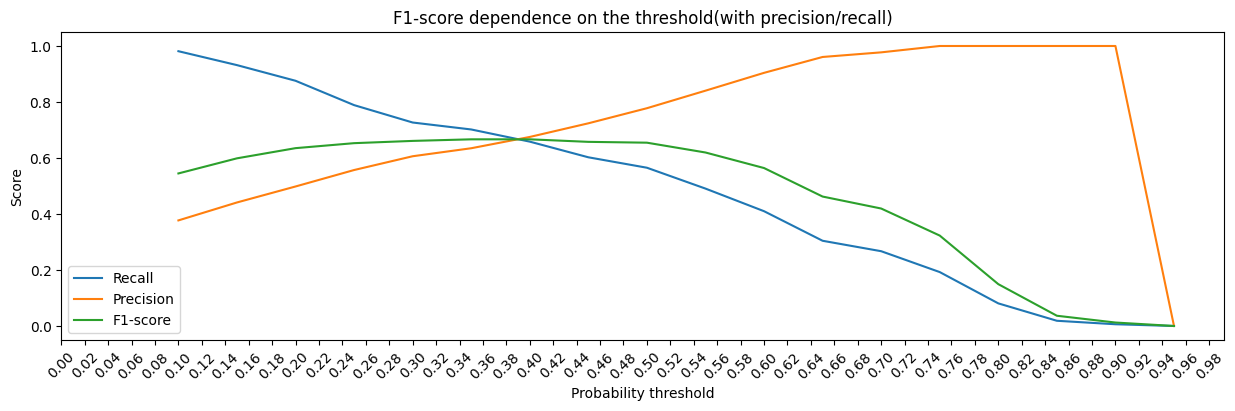

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       329
           1       0.67      0.67      0.67       161

    accuracy                           0.78       490
   macro avg       0.75      0.75      0.75       490
weighted avg       0.78      0.78      0.78       490



In [25]:
# Let's highlight the estimates of the probability of predictions
y_test_proba_pred = pd.Series(rf.predict_proba(X_test)[:, 1])

# Lists of metrics 
recall_scores = []
precision_scores = []
f1_scores = []

# Thresholds for probability estimation
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    # If the probability estimate is greater than the threshold, we refer it to сlass 1
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

# Scores visualization depend threshold
fig, ax = plt.subplots(figsize=(15, 4))

# Lines
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')

# Labels
ax.set_title('F1-score dependence on the threshold(with precision/recall)')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

# Ticks
plt.xticks(np.arange(0, 1, 0.02), rotation=45)

# Legend
ax.legend()

plt.show()

# Optimal probability threshold
thresholdOpt = 0.39

# If the probability estimate is greater than the threshold, we refer it to сlass 1
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > thresholdOpt else 0)

print(metrics.classification_report(y_test, y_test_pred_opt))

> В итоге удалось достичь значения F1-меры 0.67, при этом пробовали использовать логистическую регрессию, улучшая ее подбором параметров регуляризации, добавлением полиномиальных признаков 3 степени, а так же подбором порога вероятности отношения объекта к определенному классу. Однако самым эффективным оказался случайный лес, который показал лучший результат, хотя его результаты сравнимы с результатами дерева решений, но на тестовой выборке именно данный алгоритм показал лучший результат. При этом после подбора порога принятия решений итоговая метрика(F1-мера) улучшилась, при этом достигается оптимальный баланс между полнотой и точностью алгоритма.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [40]:
# User data
user = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
data = pd.concat([pd.DataFrame(user), churn_df.drop('Exited', axis=1)])

# Data preprocessing
# Creating features
data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
data['TenureByAge'] = data['Tenure'] / data['Age']
data['CreditScoreGivenAge'] = data['CreditScore'] / data['Age']

# Encoding by Category Encoders
types = data.dtypes
categoricalFeatures = list(types[types == 'object'].index)

encoder = ce.OneHotEncoder(cols=categoricalFeatures, use_cat_names=True)
data_enc = encoder.fit_transform(data[categoricalFeatures])
data = pd.concat([data, data_enc], axis=1)

# Delete useless
data = data.drop(categoricalFeatures, axis=1)

probabilityChurn = rf.predict_proba([data.iloc[0]])[:, 1]

print('Probability of customer churn:', probabilityChurn[0].round(2))

Probability of customer churn: 0.6
